In [126]:
import math
import holdem.utils
import numpy as np
import gym
import holdem
from treys import Card
import holdem.DQN as DQN
import holdem.safePlayer as safePlayer
import tensorflow as tf

class action_table:
  CHECK = 0
  CALL = 1
  RAISE = 2
  FOLD = 3
    
def transferCard(cards):
    result = []
    for i in cards:
        rank = Card.get_rank_int(i)
        suit = Card.get_suit_int(i)
        suit = int(math.log2(suit))
        result.append(suit * 13 + rank)
    one_hot_encoding = np.zeros(52)
    one_hot_encoding[result] += 1
    return one_hot_encoding
        
def run_maze(model_list):
    step = 0
    how_many_round_ = [0,0,0,0]
    stack_record=[]
    last_rews = [500000, 500000, 500000, 500000]
    for episode in range(15000):
        # initial observation
        (player_states, (community_infos, community_cards)) = env.reset()
        (player_infos, player_hands) = zip(*player_states)
        current_player = community_infos[-1]
        totalpot = community_infos[3]
        to_call = community_infos[6]
        stack = player_infos[current_player][2]
        handrank = player_infos[current_player][4]
        betting = player_infos[current_player][6]
        cards = [x for x in community_cards if x!=-1] + player_hands[current_player] * 2
        cards = transferCard(cards)
        
        # print(community_infos)
        
        # env.render(mode='human')
        terminal = False
        how_many_round=[0,0,0,0]
        if episode%1000==0:
            print(episode/1000, ' round finished')
        
        while not terminal:
            RL = model_list[current_player]
            action = RL.choose_action(np.concatenate(([
                                    totalpot,
                                    to_call,
                                    stack - 500000,
                                    handrank,
                                    betting],cards)))
            # first reound cannot check
#             print(action == 1 and to_call == 0)
#             print('action = ',action)
#             print()
#             if (action == 0 and cards.sum() == 2.0):
#                 action = 1
            if(action == 1 and to_call == 0):
                action = 0
            # cannot check when encounter other raised
            elif(action == 0 and to_call != 0):
                action = 1
            elif(action == 3 and to_call == 0):
                action = 0
            # print(action, cards.sum())
            result = [[0,0],[0,0],[0,0],[0,0]]
            result[current_player][0] = action
            if action==2:
                if stack < community_infos[5]:
                    result[current_player][0] = 1
                else:
                    result[current_player][1] = max(community_infos[4] + 10, 25)
            action = result
            # print(to_call)
#             print('action = ',action)
#             print('to_call = ', to_call)
            # rewards is an array
            (player_states_, (community_infos_, community_cards_)), rews, terminal, info = env.step(action)
#             env.render(mode='human')
            (player_infos_, player_hands_) = zip(*player_states)
#             print('rewards = ', rews)
#             print('terminal = ', terminal)
#             print(stack)
#             print('to_call= ',to_call)
            current_player_ = community_infos_[-1]
            betting_ = player_infos_[current_player][6]
            totalpot_ = community_infos_[3]
            to_call_ = community_infos_[6]
            stack_ = player_infos_[current_player][2]
            handrank_ = player_infos_[current_player][4]
            betting_ = player_infos_[current_player][6]
            cards_ = [x for x in community_cards_ if x!=-1] + player_hands[current_player_] 
            cards_ = transferCard(cards_)
            
            
            RL.store_transition(np.concatenate(([
                                totalpot,
                                to_call,
                                stack -500000,
                                handrank,
                                betting] , cards))
                                , action, rews, np.concatenate(([ 
                                                        totalpot_,
                                                        to_call_,
                                                        stack_-500000,
                                                        handrank_,
                                                        betting_], cards_)), current_player)

            
            # swap observation
            how_many_round[current_player] += 1
            
            stack = stack_
            current_player = current_player_
            betting = betting_
            to_call = to_call_
            player_states = player_states_
            community_infos = community_infos_
            community_cards = community_cards_
#             env.render(mode='human')
            #print('========step{} finished========'.format(step))
            step += 1
        stack_record.append(rews)
        this_round_rew = [0, 0, 0, 0]
        for i in range(len(this_round_rew)):
            this_round_rew[i] = rews[i] - last_rews[i]
#         print('replace reward as ', this_round_rew)
#         print('rews= ', rews)
#         print('last_rews= ', last_rews)
        last_rews = rews
        for i in range(len(this_round_rew)):
            if this_round_rew[i] < 0:
                this_round_rew[i] *= 10
#         for i in range(len(this_round_rew)):
#             if this_round_rew[i] > 0:
#                 this_round_rew[i] = 1
#             elif this_round_rew[i] < 0:
#                 this_round_rew[i] = -1
#             else:
#                 this_round_rew[i] = 0
        
        for i in range(4):
            model_list[i].replace_transition(this_round_rew[i], how_many_round_[i], how_many_round[i])
        if (step > 100):
            for i in range(4):
                model_list[i].learn()
    return stack_record
            

# env = gym.make('TexasHoldem-v1') # holdem.TexasHoldemEnv(2)

# # start with 2 players
# env.add_player(0, stack=500000) # add a player to seat 0 with 2000 "chips"
# env.add_player(1, stack=500000) # add another player to seat 1 with 2000 "chips"
# env.add_player(2, stack=500000)
# env.add_player(3, stack=500000)
# env.add_player(4, stack=500000)
# env.add_player(5, stack=500000)
# env.add_player(6, stack=500000)
# env.add_player(7, stack=500000)

# tf.reset_default_graph()

# RL1 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.01,
#                   reward_decay=0.9,
#                   e_greedy=0.9,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='1'
#                   )
# RL2 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.01,
#                   reward_decay=0.9,
#                   e_greedy=0.9,
#                   replace_target_iter=100,
#                   memory_size=500,
#                   output_graph=True, nickname='2'
#                   )
# RL3 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.03,
#                   reward_decay=0.9,
#                   e_greedy=0.85,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='3'
#                   )
# RL4 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.04,
#                   reward_decay=0.9,
#                   e_greedy=0.8,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='4'
#                   )
SP = safePlayer.safePlayer()
# RL5 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.05,
#                   reward_decay=0.9,
#                   e_greedy=0.75,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='5'
#                   )
# RL6 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.1,
#                   reward_decay=0.9,
#                   e_greedy=0.7,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='6'
#                   )
# RL7 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.3,
#                   reward_decay=0.9,
#                   e_greedy=0.65,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='7'
#                   )
# RL8 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.5,
#                   reward_decay=0.9,
#                   e_greedy=0.6,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='8'
#                   )
# final_result=[]
# for i in range(10):
#     stack_record = run_maze([SP, RL2, SP, SP])
#     final_result.append(stack_record)
# RL2.save_model()

## save model

In [131]:
for i in range(1):
    env = gym.make('TexasHoldem-v1') # holdem.TexasHoldemEnv(2)

    # start with 2 players
    env.add_player(0, stack=500000) # add a player to seat 0 with 2000 "chips"
    env.add_player(1, stack=500000) # add another player to seat 1 with 2000 "chips"
    env.add_player(2, stack=500000)
    env.add_player(3, stack=500000)
    final_result=[]
    for i in range(3):
        stack_record = run_maze([RL2, SP, SP, SP])
        final_result.append(stack_record)
RL2.save_model()

0.0  round finished
1.0  round finished
2.0  round finished
3.0  round finished
4.0  round finished
5.0  round finished
6.0  round finished
7.0  round finished
8.0  round finished
9.0  round finished
10.0  round finished
11.0  round finished
12.0  round finished
13.0  round finished
14.0  round finished
0.0  round finished
1.0  round finished
2.0  round finished
3.0  round finished
4.0  round finished
5.0  round finished
6.0  round finished
7.0  round finished
8.0  round finished
9.0  round finished
10.0  round finished
11.0  round finished
12.0  round finished
13.0  round finished
14.0  round finished
0.0  round finished
1.0  round finished
2.0  round finished
3.0  round finished
4.0  round finished
5.0  round finished
6.0  round finished
7.0  round finished
8.0  round finished
9.0  round finished
10.0  round finished
11.0  round finished
12.0  round finished
13.0  round finished
14.0  round finished


## load model

In [130]:
import math
import holdem.utils
import numpy as np
import gym
import holdem
from treys import Card
import holdem.DQN as DQN
import holdem.safePlayer as safePlayer
import tensorflow as tf

class action_table:
  CHECK = 0
  CALL = 1
  RAISE = 2
  FOLD = 3
tf.reset_default_graph()
RL2 = DQN.DeepQNetwork(4, 57,
                  learning_rate=0.00001,
                  reward_decay=0.999,
                  e_greedy=0.9,
                  replace_target_iter=15000,
                  memory_size=50,
                  output_graph=True, nickname='2'
                  )
RL2.load_model()

INFO:tensorflow:Restoring parameters from ./models/model.ckpt


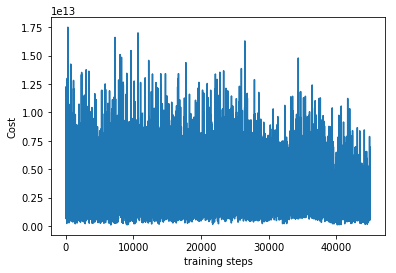

In [120]:
RL2.plot_cost()

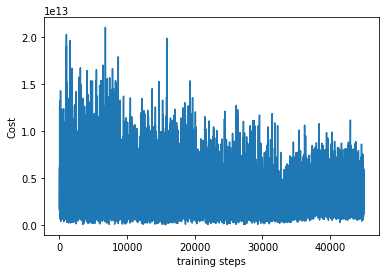

In [124]:
RL2.plot_cost()

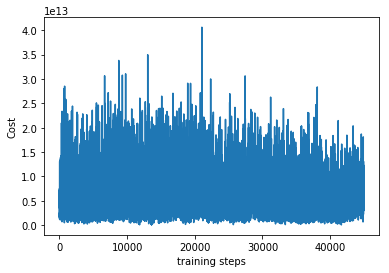

In [132]:
import matplotlib.pyplot as plt
RL2.plot_cost()

/usr/local/lib/python3.6/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


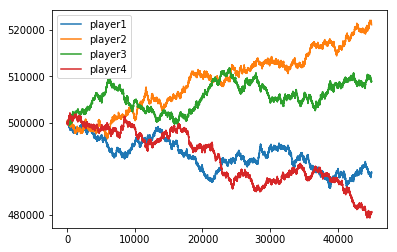

In [134]:
import matplotlib.pyplot as plt

a0=np.array(final_result[0]+final_result[1]+final_result[2])
# a1=np.array(final_result[1])
# a2=np.array(final_result[2])
# a3=np.array(final_result[3])
# stack_record = np.concatenate((a0, a1, a2))
stack_record = a0

test = np.array(stack_record)
test = np.transpose(test)
l1 = plt.plot(np.arange(len(test[0])), test[0])
l2 = plt.plot(np.arange(len(test[1])), test[1])
l3 = plt.plot(np.arange(len(test[2])), test[2])
l4 = plt.plot(np.arange(len(test[3])), test[3])
# l5 = plt.plot(np.arange(len(test[4])), test[4])
# l6 = plt.plot(np.arange(len(test[5])), test[5])
# l7 = plt.plot(np.arange(len(test[6])), test[6])
# l8 = plt.plot(np.arange(len(test[7])), test[7])
plt.legend([l1,l2,l3,l4],labels=['player1','player2','player3','player4'])
plt.show()

In [7]:
from websocket import create_connection
import json

In [28]:
ws = create_connection("ws://poker-training.vtr.trendnet.org:3001")
ws.send(json.dumps({
            "eventName": "__join",
            "data": {
                "playerName": "ppp"
            }
        }))
ws.recv()

'{"eventName":"__new_peer","data":[{"playerName":"f27f6f1c7c5cbf4e3e192e0a47b85300","isOnline":true},{"playerName":"828d51c39c87aad9b1407d409fa58e36","isOnline":true},{"playerName":"050fcc102c8dcc764e8342234da8d78f","isOnline":true},{"playerName":"17a169e8c69b2effd9315975ac833b78","isOnline":true},{"playerName":"a13fdaf9882ebf07cfea5f73df976e39","isOnline":true},{"playerName":"2c87c27ae47f26e13a880e32fa2db327","isOnline":true},{"playerName":"afb1c65720dc617c16b471157a0398b4","isOnline":true}]}'

In [29]:
ws.close()